In [ ]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# 데이터 준비 (MNIST 데이터)
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

In [ ]:
# 정규화
train_data = [(x.unsqueeze(0)/255, y) for x, y in zip(train_dataset.data, train_dataset.targets)]
test_data = [(x.unsqueeze(0)/255, y) for x, y in zip(test_dataset.data, test_dataset.targets)]

In [ ]:
# hyper parameter 설정
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# DataLoader 
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
# ll = nn.Linear(1,3)

In [ ]:
# ll.weight

In [ ]:
# CNN model 생성
# Convolution, Maxpooling, flatten
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.2)
    )
    self.softmax = nn.Softmax()
    self.fc = nn.Linear(7*7*32,10)
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    x = self.softmax(x)
    return x

In [ ]:
model = CNN()

In [ ]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

- 학습 상황 시각화
- 성능 지표 표시 : ex) 정확도
- 최적 성능 모델 저장
- early stopping
- 기타 등등 필요성이 느껴지는 문제 하나 해결

99번째 train_loss : 1.55 test_loss : 1.54 Accuracy : 92.12%


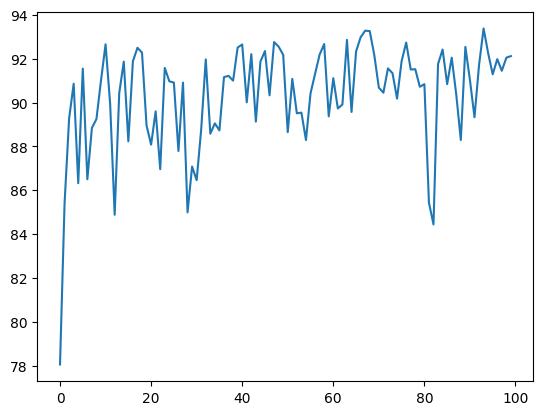

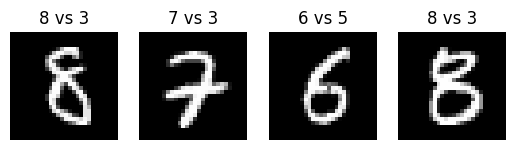

In [ ]:
import numpy as np
from tqdm.auto import tqdm
from IPython.display import clear_output

total_acc = []
total_score = []

best_acc = 0 
best_epoch = 0 

for epoch in range(EPOCHS):

  # train data 
  train_loss=[]
  for img, label in train_loader:
    optimizer.zero_grad()
    pred = model(img)

    loss = criterion(pred, label)
    loss.backward()

    optimizer.step()
    train_loss.append(loss.item())

  # test data 
  test_loss=[]
  test_sources = []

  with torch.no_grad():
    for img, label in test_loader:
      pred = model(img)
      loss = criterion(pred, label)

      test_loss.append(loss.item())
      test_sources.append((img[pred.argmax(axis=1)!=label], label[pred.argmax(axis=1)!=label],pred.argmax(axis=1)[pred.argmax(axis=1)!=label])) # label과 pred 값이 다른 부분만 test_sources에 담기
  
  # 노트북 파일 기존 프린트 되었던 화면을 지우는 코드
  clear_output()

  f_preds = np.hstack(test_f1_score_pred)
  f_labels = np.hstack(test_f1_score_label)

  score = f1_score(f_preds, f_labels, average='weighted') # f1 score 적용 코드

  # 인식 잘 안된 부분의 시각화를 위해서 img, label, pred를 모아서 정리
  imgs = [x[0] for x in test_sources]
  imgs = torch.cat(imgs, axis=0)

  labels = [x[1] for x in test_sources]
  labels = torch.cat(labels, axis=0)

  preds = [x[2] for x in test_sources]
  preds = torch.cat(preds, axis=0)

  # 정확도 계산을 위한 코드. 다양하게 다른 방법도 가능함
  # sklearn의 metric 이용하는 방법 추천
  wrongs = [len(x[0]) for x in test_sources]
  acc = round(100-(sum(wrongs)/100),2)

  # 정확도 추이를 보기 위하여 각 에폭에서의 정확도 정보 수집
  total_acc.append(acc)
  total_score.append(score)

  # 학습 진행 상황 출력
  print("{}번째 train_loss : {} test_loss : {} Accuracy : {}%".format(epoch, round(np.array(train_loss).mean(),2),round(np.array(test_loss).mean(),2),
                                                                   acc))
  if img.shape[0]<1:continue # 혹시 더이상 오분류 내용이 없으면 지나가도록 세팅

  #가장 높은 정확도를 달성한 epoch 정보 저장
  if acc > best_acc:
    best_acc = acc
    best_epoch = epoch

  print("Best accuracy {}% achieved at epoch {}".format(best_acc, best_epoch))

  # 정확도 그래프 그리기
  plt.plot(total_acc)
  plt.show()

  plt.plot(total_score)
  plt.show()

  # 오분류 내용이 어떤건지 알기 위해 오분류 내용 4개 뽑아서 label과 pred 글자 넣어서 표시
  for i in range(4):
    plt.subplot(1,4,i+1)    
    plt.imshow(imgs[i][0], cmap='gray')    

    plt.title("{} vs {}".format(labels[i].item(),preds[i].item()))
    plt.axis('off')

  plt.show()